# What is the most optimal skill to learn for data scientists?

Methodology:
1. Group skills to determine median salary and likelihood of being in a job posting
2. Visualize median salary vs percent skill demand
3. Determine if certain technologies are more prevalant

In [1]:
# import libraries
import ast
import pandas as pd
from datasets import load_dataset
import matplotlib.pyplot as plt
import seaborn as sns

# load data
dataset = load_dataset('lukebarousse/data_jobs')
df = dataset['train'].to_pandas()

# clean data
df['job_posted_date'] = pd.to_datetime(df['job_posted_date'])
df['job_skills'] = df['job_skills'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else x)

In [2]:
# filter to only data scientist postings in the US
df_ds_US = df[(df['job_title_short'] == 'Data Scientist') & (df['job_country'] == 'United States')].copy()

In [3]:
# drop jobs with no listed salary and explode out job skills column
df_ds_US = df_ds_US.dropna(subset = ['salary_year_avg'])

df_ds_US_exploded = df_ds_US.explode('job_skills')

df_ds_US_exploded[['salary_year_avg', 'job_skills']].head(5)

,salary_year_avg,job_skills
100,228222.0,sql
100,228222.0,r
100,228222.0,python
100,228222.0,express
116,114000.0,r


In [11]:
# group these skills by median salary and count and rename columns
df_ds_skills = df_ds_US_exploded.groupby('job_skills')['salary_year_avg'].agg(['count', 'median']).sort_values(by = 'count', ascending = False)

df_ds_skills = df_ds_skills.rename(columns = {'count': 'skill_count', 'median': 'median_salary'})

# create a column for the likelihood that skill is in a job posting
ds_job_count = len(df_ds_US)

df_ds_skills['skill_percent'] = df_ds_skills['skill_count'] / ds_job_count * 100

# filter out skill percents less than 10%
skill_percent = 10

df_ds_skills_high_demand = df_ds_skills[df_ds_skills['skill_percent'] > skill_percent]

df_ds_skills_high_demand

,skill_count,median_salary,skill_percent
job_skills,,,
python,3358,131867.0,73.753569
sql,2463,134500.0,54.096200
r,2053,126000.0,45.091149
sas,1022,120000.0,22.446738
tableau,989,125000.0,21.721942
aws,768,134000.0,16.867999
spark,718,135959.5,15.769822
excel,490,124290.0,10.762135
tensorflow,474,149646.0,10.410718


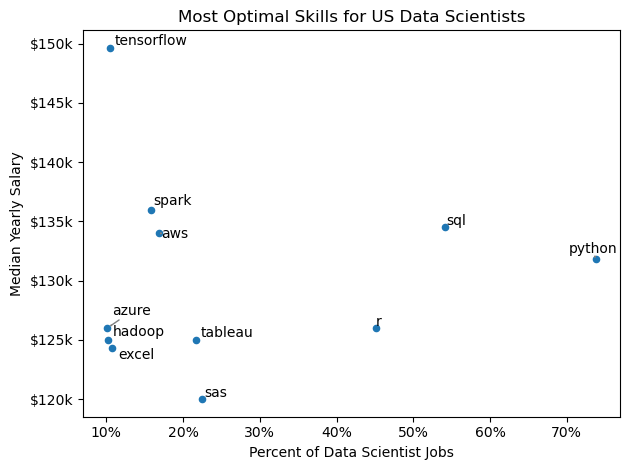

In [17]:
from adjustText import adjust_text

df_ds_skills_high_demand.plot(kind = 'scatter', x = 'skill_percent', y = 'median_salary')

# prepare texts for adjustText
texts = []
for i, txt in enumerate(df_ds_skills_high_demand.index):
    texts.append(plt.text(df_ds_skills_high_demand['skill_percent'].iloc[i], df_ds_skills_high_demand['median_salary'].iloc[i], txt))

# adjust text to avoid overlap
adjust_text(texts, arrowprops = dict(arrowstyle = '->', color = 'grey', lw = 1))

# set axis lables, title, and legend
plt.xlabel('Percent of Data Scientist Jobs')
plt.ylabel('Median Yearly Salary')
plt.title('Most Optimal Skills for US Data Scientists')
plt.tight_layout()

from matplotlib.ticker import PercentFormatter
ax = plt.gca()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, pos: f'${int(y/1000)}k'))
ax.xaxis.set_major_formatter(PercentFormatter(decimals = 0))

# adjust label and display plot
plt.tight_layout()
plt.show()

In [19]:
# create seperate dataframe for which type of technology each skill falls under
df_technology = df['job_type_skills'].copy()

# remove duplicates
df_technology = df_technology.drop_duplicates()

# remove NaN values
df_technology = df_technology.dropna()

# combine all dictionaries into one
technology_dict = {}
for row in df_technology:
    row_dict = ast.literal_eval(row) # convert string to dictionery
    for key, value in row_dict.items():
        if key in technology_dict: # if key already exists in technology_dict, add value to existing dictionery
            technology_dict[key] += value
        else:                      # if key does not exist in technology_dict, add both key and value
            technology_dict[key] = value

# remove duplicates by converting values to set them back to list
for key, value in technology_dict.items():
    technology_dict[key] = list(set(value))

technology_dict

{'analyst_tools': ['spss',
  'tableau',
  'ssrs',
  'sheets',
  'powerpoint',
  'looker',
  'alteryx',
  'sap',
  'esquisse',
  'splunk',
  'ms access',
  'sas',
  'cognos',
  'nuix',
  'powerbi',
  'word',
  'spreadsheet',
  'microstrategy',
  'datarobot',
  'msaccess',
  'qlik',
  'ssis',
  'excel',
  'visio',
  'sharepoint',
  'dax',
  'outlook',
  'power bi'],
 'programming': ['bash',
  'javascript',
  'c++',
  'c',
  'assembly',
  'crystal',
  'typescript',
  'lua',
  'groovy',
  'nosql',
  'f#',
  'objective-c',
  'elixir',
  'visualbasic',
  'r',
  'erlang',
  't-sql',
  'rust',
  'perl',
  'scala',
  'sass',
  'sas',
  'mongo',
  'html',
  'c#',
  'sql',
  'vba',
  'julia',
  'pascal',
  'powershell',
  'haskell',
  'solidity',
  'lisp',
  'shell',
  'java',
  'mongodb',
  'no-sql',
  'apl',
  'matlab',
  'golang',
  'clojure',
  'ocaml',
  'dart',
  'cobol',
  'python',
  'vb.net',
  'go',
  'php',
  'swift',
  'css',
  'ruby',
  'fortran',
  'visual basic',
  'delphi',
  'kot

In [21]:
# create new dataframe with technology and skills columns
df_technology = pd.DataFrame(list(technology_dict.items()), columns = ['technology', 'skills'])

df_technology = df_technology.explode('skills')

df_technology

,technology,skills
0,analyst_tools,spss
0,analyst_tools,tableau
0,analyst_tools,ssrs
0,analyst_tools,sheets
0,analyst_tools,powerpoint
...,...,...
9,sync,twilio
9,sync,zoom
9,sync,wire
9,sync,mattermost


In [23]:
# merge this new dataframe back to the df_ds_skills_high_demand dataframe
df_plot = df_ds_skills_high_demand.merge(df_technology, left_on = 'job_skills', right_on = 'skills')

df_plot

,skill_count,median_salary,skill_percent,technology,skills
0,3358,131867.0,73.753569,programming,python
1,2463,134500.0,54.096200,programming,sql
2,2053,126000.0,45.091149,programming,r
3,1022,120000.0,22.446738,analyst_tools,sas
4,1022,120000.0,22.446738,programming,sas
5,989,125000.0,21.721942,analyst_tools,tableau
6,768,134000.0,16.867999,cloud,aws
7,718,135959.5,15.769822,libraries,spark
8,490,124290.0,10.762135,analyst_tools,excel
9,474,149646.0,10.410718,libraries,tensorflow


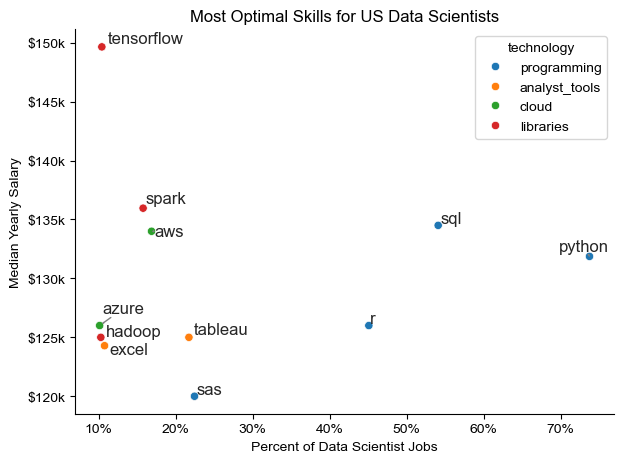

In [28]:
# now plot the new dataframe using seaborn to distinguish which skills fall under which type of technology category
from adjustText import adjust_text

# old matplotlib plot method = df_plot.plot(kind = 'scatter', x = 'skill_percent', y = 'median_salary')
sns.scatterplot(
    data = df_plot,
    x = 'skill_percent',
    y = 'median_salary',
    hue = 'technology'
)

sns.despine()
sns.set_theme(style = 'ticks')

texts = []
for i, txt in enumerate(df_ds_skills_high_demand.index):
    texts.append(plt.text(df_ds_skills_high_demand['skill_percent'].iloc[i], df_ds_skills_high_demand['median_salary'].iloc[i], txt))

adjust_text(texts, arrowprops = dict(arrowstyle = '->', color = 'grey', lw = 1))

plt.xlabel('Percent of Data Scientist Jobs')
plt.ylabel('Median Yearly Salary')
plt.title('Most Optimal Skills for US Data Scientists')
plt.tight_layout()

from matplotlib.ticker import PercentFormatter
ax = plt.gca()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, pos: f'${int(y/1000)}k'))
ax.xaxis.set_major_formatter(PercentFormatter(decimals = 0))

plt.tight_layout()
plt.show()